# Training SVM

<a href="https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">Guide to SVM Training</a>

### To-do:
<ul>
    <li> Find and track optimal parameters for SVM </li>
    <li> Modify generate data function to include outside subject data w/ normalization </li>
    <li> Track accuracy report </li>
</ul>

In [311]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output

In [12]:
subjects

['AT', 'CC', 'CG', 'GD', 'JM', 'JR', 'JS', 'NL', 'RK', 'SC', 'TP', 'YY']

In [25]:
'''
Gets a list of subject IDs and file suffix, given a path to the data files

Note: subject ID must be only 2 characters for this to work, and all data files
must have same suffix
'''
def get_subjects(path):
    
    files = os.listdir(path)
    subjects = [f[:2] for f in files]
    suffix = files[0][2:]
    subjects.remove('ML')
    subjects.sort()
    
    return subjects, suffix

In [58]:
'''
Randomly selects half of the labels in the data to switch to the other class. 

y_data:   list of the label data
classes:  list of the two different classes of labels
'''
def scramble_labels(y_data, classes):
    
    for index in np.nditer(np.random.choice(len(y_data), size=len(y_data)//2, replace=False)):
        
        if y_data[index] == classes[0]:
            # print("%i: %s -> %s" % (index, y_data[index], classes[1]))
            y_data[index] = classes[1]
        else:
            # print("%i: %s -> %s" % (index, y_data[index], classes[0]))
            y_data[index] = classes[0]


In [9]:
'''
Gets individuals subject data.

path:          directory to data files
subject:       specific subject data to load
suffix:        ending to filename
roi:           0 for MT data, 1 for V1 data
conds:         which conditional dataset to extract
block_length:  standardized number of voxels per block
'''
def extract_subject_data(path, subject, suffix, roi, conds, block_length):
    
    x_data = []
    y_data = []
    
    path_to_file = path + subject + suffix
    mat = scipy.io.loadmat(path_to_file)['roi_scanData'][0][roi]
        
    for scan in range(len(mat[0])):
            
        for cond in conds:
            
            for block in range(len(mat[0][scan][0][cond][0])):

                block_data = []
                for tr in range(len(mat[0][scan][0][cond][0][block][0])):
                    
                    # Extract all voxel data from individual TRs
                    block_data.extend(mat[0][scan][0][cond][0][block][0][tr][0][0][0].tolist())
                
                # Filters for most active voxels in each block
                block_data.sort()
                block_data = block_data[-block_length:]
                
                x_data.append(block_data)
                y_data.append(mat[0][scan][1][cond][0])
                
    data = {'x': x_data, 'y': y_data}
    return data

In [344]:
'''
Performs grid search to find best possible parameters from selections to train data.
'''
def get_optimal_params(x_data, y_data, gamma_range, C_range):
    
    gamma_vals = np.logspace(gamma_range['start'], gamma_range['stop'], gamma_range['num'], base=gamma_range['base'])
    C_vals = np.logspace(C_range['start'], C_range['stop'], C_range['num'], base=C_range['base'])
    
    tuned_params = [{'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': gamma_vals, 'C': C_vals}]
    
    clf = GridSearchCV(SVC(), tuned_params, cv=5, iid=True)
    clf.fit(x_data, y_data)
    
    round1_params = clf.best_params_
    
    gamma_exp = math.log(round1_params['gamma'], gamma_range['base'])
    C_exp = math.log(round1_params['C'], C_range['base'])
    
    new_gamma_range = np.logspace(gamma_exp-1, gamma_exp+1, 6, base=gamma_range['base'])
    new_C_range = np.logspace(C_exp-1, C_exp+1, 6, base=C_range['base'])
    
    tuned_params = [{'kernel': [round1_params['kernel']], 'gamma': new_gamma_range, 'C': new_C_range}]
    
    clf = GridSearchCV(SVC(), tuned_params, cv=5, iid=True)
    clf.fit(x_data, y_data)
    
    return clf.best_params_
    

In [241]:
'''
Generates training and testing data.
'''
def generate_data(subjects, inner_test_subject, outer_test_subject, path, suffix, block_length, roi, conds):
    
    data = []
    
    x_train = []
    y_train = []
    
    x_test_inner = []
    y_test_inner = []
    
    x_test_outer = []
    y_test_outer = []
    
    for subject in range(len(subjects)):
        
        subject_data = extract_subject_data(path, subjects[subject], suffix, roi, conds, block_length)
        if subject == outer_test_subject:
            x_test_outer.extend(subject_data['x'])
            y_test_outer.extend(subject_data['y'])
        elif subject == inner_test_subject:
            x_test_inner.extend(subject_data['x'])
            y_test_inner.extend(subject_data['y'])
        else:
            x_train.extend(subject_data['x'])
            y_train.extend(subject_data['y'])
    
    x_train_len = len(x_train)
    x_test_outer_len = len(x_test_outer)
    
    data.extend(x_train)
    data.extend(x_test_outer)
    data.extend(x_test_inner)
    
    # MinMaxScaler scales each feature to values between 0 and 1 among all x data
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_normalized = scaler.fit_transform(data)
    x_train, x_test_outer, x_test_inner = x_normalized[:x_train_len], x_normalized[x_train_len:x_train_len+x_test_outer_len], x_normalized[x_train_len+x_test_outer_len:]

    y_train = np.stack(y_train, axis=0)
    
    return x_train, y_train, x_test_inner, y_test_inner, x_test_outer, y_test_outer

In [347]:
'''
Trains the classifier, uses nested cross-validation.

path:          path to data files
roi:           0 for V1, 1 for MT
conds:         which conditional dataset to extract
block_length:  standardized number of voxels per block
scramble:      boolean value specifying whether training labels should be scrambled
'''
def train(path, roi, conds, block_length, gamma_range, C_range, scramble=False):
    
    subjects, suffix = get_subjects(path)
    acc_report = pd.DataFrame(index=subjects, columns=subjects)
    outer_accs = []
    
    for outer_subject in range(len(subjects)):
        
        print("Currently on outer subject #%i." % (outer_subject))

        dummy_subject = 0
        if outer_subject == 0:
            dummy_subject = 1;
        _, _, _, _, x_test_outer, y_test_outer = generate_data(subjects, dummy_subject, outer_subject, path, suffix, block_length, roi, conds)
        
        best_params = None
        best_acc = None
        start_time = time.time()
        
        for inner_subject in range(len(subjects)):

            if inner_subject == outer_subject:
                continue

            print("Currently on inner subject #%i." % (inner_subject))    
            x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
            
            if scramble:
                scramble_labels(y_train, classes)
                
            params = get_optimal_params(x_train, y_train, gamma_range, C_range)    
            
            # train model
            svclassifier = SVC(kernel=params['kernel'], gamma=params['gamma'], C=params['C'], max_iter=-1)
            #svclassifier = SVC(kernel=kernel_type, gamma='auto')
            svclassifier.fit(x_train, y_train)
            
            acc = svclassifier.score(x_train, y_train)
            if best_params == None or acc > best_acc:
                best_params = params
                best_acc = acc
            
            index = subjects[outer_subject]
            col = subjects[inner_subject]
            acc_report.at[index, col] = acc

        print('Testing outer subject...')
        svclassifier = SVC(kernel=best_params['kernel'], gamma=best_params['gamma'], C=best_params['C'], max_iter=-1)
        svclassifier.fit(x_test_outer, y_test_outer)
        clear_output()
        
        outer_acc = svclassifier.score(x_test_outer, y_test_outer)
        outer_accs.append(acc)
        
        end_time = time.time()
        exec_time = end_time - start_time
        minutes = exec_time // 60
        seconds = exec_time % 60
        print('Last turn took %i minutes and %f seconds.' % (minutes, seconds))
    
    clear_output()
    return acc_report, outer_accs

## Training model for accuracy

For rbf kernel, should check grid points to find good values of C and gamma (necessary for performance) <br>
<a href="https://scikit-learn.org/stable/modules/svm.html#parameters-of-the-rbf-kernel"> sklearn.model_selection.GridSearchCV </a><br>

In [ ]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}
gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}

accs_scrambled, outer_accs_scrambled = train(path, roi, conds, block_length, gamma_range, C_range, scramble=True)

Currently on outer subject #0.
Currently on inner subject #1.
{'C': 128.0, 'gamma': 0.125, 'kernel': 'rbf'}
{'C': 111.43047210190387, 'gamma': 0.1435872943746294, 'kernel': 'rbf'}
Currently on inner subject #2.
{'C': 2.0, 'gamma': 0.03125, 'kernel': 'sigmoid'}
{'C': 3.0314331330207964, 'gamma': 0.03589682359365735, 'kernel': 'sigmoid'}
Currently on inner subject #3.


In [266]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624

accs, outer_accs = train(path, roi, conds, block_length)
accs.to_csv('no_scramble.csv', sep='\t')

Testing outer subject...


(array([12., 74., 30.,  0.,  0.,  0.,  2.,  0.,  2., 12.]),
 array([0.47727273, 0.52954545, 0.58181818, 0.63409091, 0.68636364,
        0.73863636, 0.79090909, 0.84318182, 0.89545455, 0.94772727,
        1.        ]),
 <a list of 10 Patch objects>)

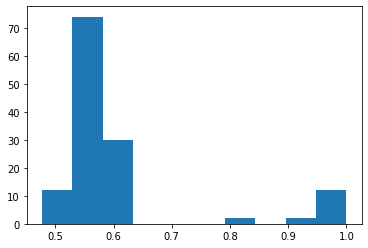

In [267]:
vals = []
for column in accs:
    vals.extend(accs[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals)

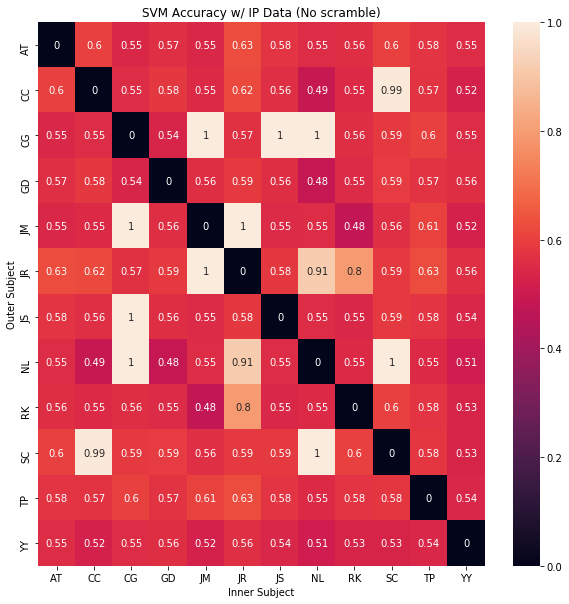

In [304]:
import seaborn as sns

plt.figure(figsize=(10,10))
ax = sns.heatmap(accs.fillna(value=0), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('SVM Accuracy w/ IP Data (No scramble)')
ax.set_ylabel('Outer Subject')
ax.set_xlabel('Inner Subject')
plt.savefig('acc_heatmap.png')

In [ ]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624 

accs, outer_accs = train(path, roi, conds, block_length)
vals = []
for column in accs:
    vals.extend(accs[column].tolist())
vals = [x for x in vals if str(x) != 'nan']

plt.hist(vals)

In [119]:
accs

,AT,CC,CG,GD,JM,JR,JS,NL,RK,SC,TP,YY
AT,NaN,0.601562,0.568182,0.551471,0.55303,0.628788,0.537879,0.609375,0.575758,0.53125,0.575758,0.578125
CC,0.554688,NaN,0.625,0.598485,0.554688,0.5625,0.585938,0.532258,0.5625,0.524194,0.554688,0.580645
CG,0.575758,0.546875,NaN,0.558824,0.606061,0.545455,0.606061,0.539062,0.575758,0.585938,0.537879,0.546875
GD,0.566176,0.575758,0.492647,NaN,0.580882,0.610294,0.566176,0.575758,0.551471,0.568182,0.551471,0.560606
JM,0.583333,0.546875,0.545455,0.617647,NaN,0.55303,0.568182,0.578125,0.55303,0.570312,0.560606,0.578125
JR,0.575758,0.5625,0.537879,0.595588,0.530303,NaN,0.545455,0.59375,0.621212,0.578125,0.55303,0.59375
JS,0.621212,0.515625,0.522727,0.566176,0.560606,0.590909,NaN,0.578125,0.55303,0.546875,0.537879,0.546875
NL,0.554688,0.612903,0.570312,0.598485,0.554688,0.59375,0.539062,NaN,0.59375,0.556452,0.65625,0.620968
RK,0.55303,0.617188,0.590909,0.522059,0.55303,0.55303,0.537879,0.554688,NaN,0.539062,0.583333,0.640625
SC,0.523438,0.620968,0.632812,0.590909,0.585938,0.59375,0.625,0.540323,0.601562,NaN,0.632812,0.596774


In [272]:
outer_accs

[0.5546875,
 0.5241935483870968,
 0.5546875,
 0.5606060606060606,
 0.5234375,
 0.5625,
 0.5390625,
 0.5080645161290323,
 0.53125,
 0.532258064516129,
 0.5390625,
 0.5390625]

## Histograms of Different Kernel Accuracies

Note: This is without parameter grid search

Currently testing linear kernel.
Currently testing rbf kernel.
Currently testing poly kernel.
Currently testing sigmoid kernel.


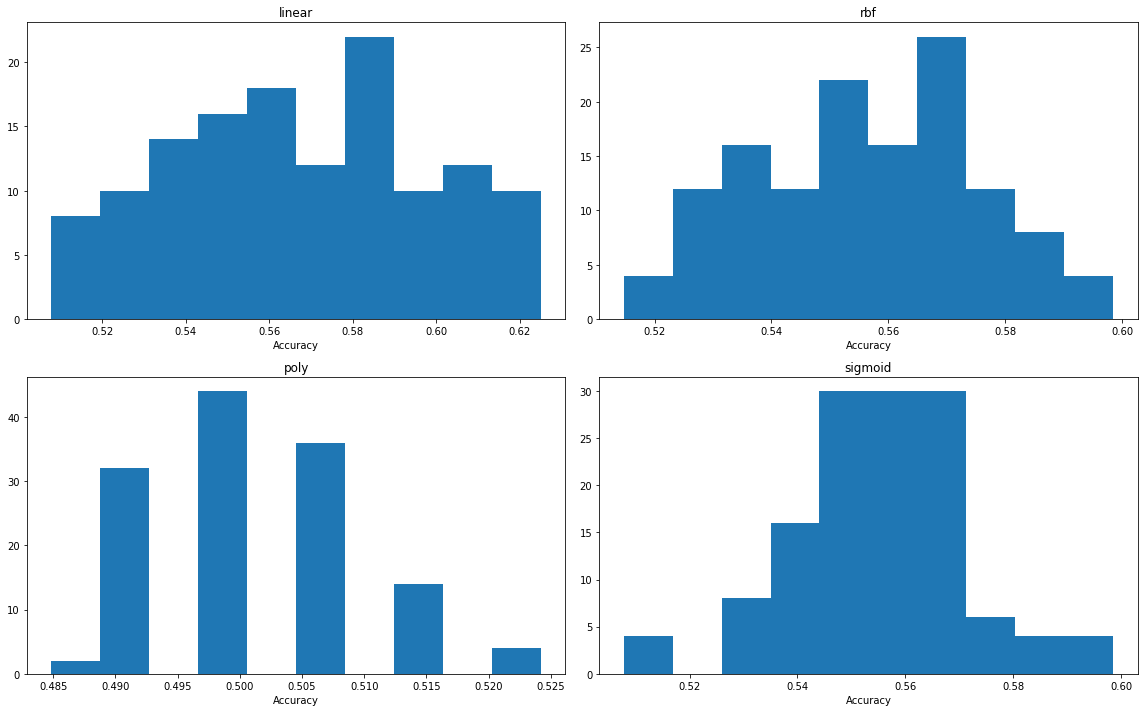

In [250]:
path = r'scans/output/PRE/'
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
block_length = 624 

kernels = ['linear', 'rbf', 'poly', 'sigmoid']
fig, axes = plt.subplots(2, 2, figsize=(16,10), squeeze=False)

kernel_accs = {}

for i, kernel in enumerate(kernels):
    
    print("Currently testing %s kernel." % (kernel))
    accs, outer_accs = train(path, kernel, roi, conds, block_length)
    kernel_accs[kernel] = accs
    vals = []
    for column in accs:
        vals.extend(accs[column].tolist())
    vals = [x for x in vals if str(x) != 'nan']
    
    row = 0
    if i > 1:
        row = 1
    col = 0
    if i == 1 or i == 3:
        col = 1
    
    axes[row, col].hist(vals)
    axes[row, col].set_title(kernel)
    axes[row, col].set_xlabel('Accuracy')

fig.tight_layout()
plt.savefig('acc_comparison.png')
plt.show()

### Debugging

In [345]:
C_range = {'start': -3, 'stop': 11, 'num': 8, 'base': 2.0}
gamma_range = {'start': -13, 'stop': 1, 'num': 8, 'base': 2.0}

start_time = time.time()
x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, 1, 0, path, suffix, block_length, roi, conds)

opt_params = get_optimal_params(x_train, y_train, gamma_range, C_range)

end_time = time.time()
exec_time = end_time - start_time
minutes = exec_time // 60
seconds = exec_time % 60
print('Operation took %i minutes and %f seconds.' % (minutes, seconds))

{'C': 8.0, 'gamma': 0.001953125, 'kernel': 'sigmoid'}
{'C': 6.964404506368992, 'gamma': 0.0029603839189656206, 'kernel': 'sigmoid'}
Operation took 1 minutes and 29.594329 seconds.


In [322]:
C_range = np.logspace(start=-3, stop=7, num=6, base=2.0)
gamma_range = np.logspace(start=-9, stop=1, num=6, base=2.0)
tuned_params = [{'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': gamma_range, 'C': C_range}]

start_time = time.time()
x_train, y_train, x_test, y_test, _, _ = generate_data(subjects, 1, 0, path, suffix, block_length, roi, conds)
clf = GridSearchCV(SVC(), tuned_params, cv=5)
clf.fit(x_train, y_train)

end_time = time.time()
exec_time = end_time - start_time
minutes = exec_time // 60
seconds = exec_time % 60
print('Operation took %i minutes and %f seconds.' % (minutes, seconds))

clf.best_params_

KeyboardInterrupt: 

In [11]:
kernel_type = 'poly'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

inner_subject = 3
outer_subject = 0
x_train, y_train, x_test, y_test = generate_data(subjects, inner_subject, outer_subject, path, suffix, block_length, roi, conds)
svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
svclassifier.fit(x_train, y_train)

svclassifier.score(x_test, y_test)


0.5

In [837]:
kernel_type = 'sigmoid'
path = r'scans/output/PRE/'
suffix = "PRE_EVERY_TR_roi.mat"
roi = 1                            # V1-roi: 0, MT-roi: 1
conds = [1, 3]                     # trained_cp: 0, trained_ip: 1, untrained_cp: 2, untrained_ip: 3
subjects = get_subjects(path)
block_length = 624                 # minimum block length

data = extract_subject_data(path, subjects[2], suffix, roi, conds, block_length)
#svclassifier = SVC(kernel=kernel_type, gamma='auto', max_iter=-1)
#svclassifier.fit(data['x'], data['y'])

In [53]:
classes = ['trained_ip', 'untrained_ip']

data = extract_subject_data(path, subjects[0], suffix, roi, conds, block_length)
scramble_labels(data['y'], classes)

0: trained_ip -> untrained_ip
5: trained_ip -> untrained_ip
6: untrained_ip -> trained_ip
8: trained_ip -> untrained_ip
7: untrained_ip -> trained_ip
1: trained_ip -> untrained_ip
